In [6]:
from util_fdp import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ABC_TABLE = {
    (0.25, 1):(0.51, 100, 20), 
    (0.25, 5):(0.51, 100, 20), 
    (0.25, 'log'):(0.51, 100, 20), 
    (0.9, 1): (0.51, 100, 20),
    (0.9, 5): (0.568, 0, 1),
    (0.9, 'log'): (0.782, 25, 2),
}
DEFAULT_ABC = (0.51, 100, 20)
def get_abc(E_typ: str, E_cons, r: float,
            default=DEFAULT_ABC, table=ABC_TABLE):
    """
    根据 (E_typ, E_cons, r) 返回 (a, b, c)。
    - E_typ ∈ {"cons", "log"}
    - E_cons ∈ {1, 5}  （当 E_typ == "cons" 时才使用）
    - r ∈ {0.25, 0.9}
    未匹配到时返回 default。
    """
    if gene_process == 'hete':
        key = (r, "log") if E_typ.lower() == "log" else (r, E_cons)
        return table.get(key, default)
    else:
        return (0.51, 100, 20)

# ── 必要导入 ───────────────────────────────────────────────────
from util_fdp import run_federated_trajectory
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
np.random.seed(2020)
# ── 全局设置（一次写好，到处复用）────────────────────────────

In [36]:
# ============================================================
#  Imports & 全局设定
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 颜色 & 样式
COLORS = {
    'global': '#0072B2',
    'c0'    : '#009E73',
    'c9'    : '#7E79D2',
    'true'  : '#666666',
}
plt.rcParams.update({
    'font.size': 13, 'axes.titlesize': 16, 'axes.labelsize': 14,
    'legend.fontsize': 12, 'lines.linewidth': 2.4,
})

# 常量
Z_LOG, Z_CONS = 6.753, 6.74735

# ============================================================
#  小工具：把 dict → (xs, ys)
# ============================================================
def _series(hist):
    xs = np.fromiter(sorted(hist), int)
    ys = np.fromiter((hist[k] for k in xs), float)
    return xs, ys

def _series_var(stats, z):
    """stats: {'q_avg': dict, 'variance': dict}"""
    xs, q   = _series(stats['q_avg'])
    _,  var = _series(stats['variance'])
    delta   = z * np.sqrt(var)
    return xs, q, q - delta, q + delta

# ============================================================
#  抽取曲线
# ============================================================
def extract_curves(N, *, mode='federated',
                   E_typ='cons', E_cons=1,
                   base_seed=2020, n_clients=10,
                   gene_process='hete', taus=0.5, rs=()):

    # -------- 运行一次训练，拿到 true_q & 轨迹 --------
    true_q, traj = run_federated_trajectory(
        dist_type='normal', taus=taus, client_rs=rs, n_clients=n_clients,
        T=N, E_typ=E_typ, E_cons=E_cons,
        gene_process=gene_process, mode=mode,
        base_seed=base_seed, a=0.51, b=100, c=2,
        T_mode='samples')                     # ← 你一直用 samples

    if mode == 'global':                     # == 旧 get_curves_global
        z   = Z_CONS
        # traj 是 {0: stats, 1: stats, ...}
        xs0, q0, lo0, up0 = _series_var(traj[0], z)
        xs9, q9, lo9, up9 = _series_var(traj[9], z)
        return dict(xs_g=None, gavg=None, lo_g=None, up_g=None,
                    xs0=xs0, q0=q0, lo0=lo0, up0=up0,
                    xs9=xs9, q9=q9, lo9=lo9, up9=up9,
                    true=true_q)

    # -------- federated 模式 --------
    z = Z_LOG if E_typ == 'log' else Z_CONS

    # Global 曲线
    g_hist  = traj['global']['global_q_avg']
    v_hist  = traj['global']['global_variance']
    xs_g, gavg = _series(g_hist)
    _,    gvar = _series(v_hist)
    lo_g, up_g = gavg - z*np.sqrt(gvar), gavg + z*np.sqrt(gvar)

    # Client 0 / 9 只有点估计
    xs0, q0 = _series(traj['local']['client_0'])
    xs9, q9 = _series(traj['local']['client_9'])

    return dict(xs_g=xs_g, gavg=gavg, lo_g=lo_g, up_g=up_g,
                xs0=xs0, q0=q0, lo0=None, up0=None,
                xs9=xs9, q9=q9, lo9=None, up9=None,
                true=true_q)

# ============================================================
#  画单面板
# ============================================================
def plot_panel(ax, d, *, title,
               show_global=True, y_lims=(-0.5, 0),
               x_max=30_000, scale=100,
               show_yticks=False, add_ylabel=False,
               add_legend=False):

    if show_global and d['gavg'] is not None:
        ax.plot(d['xs_g'], d['gavg'], color=COLORS['global'], label='Global')
        ax.fill_between(d['xs_g'], d['lo_g'], d['up_g'],
                        color=COLORS['global'], alpha=0.15)

    ax.plot(d['xs0'], d['q0'], '-.', color=COLORS['c0'], label='Client 0')
    if d['lo0'] is not None:
        ax.fill_between(d['xs0'], d['lo0'], d['up0'],
                        color=COLORS['c0'], alpha=0.25)

    ax.plot(d['xs9'], d['q9'], ':', color=COLORS['c9'], label='Client 9')
    if d['lo9'] is not None:
        ax.fill_between(d['xs9'], d['lo9'], d['up9'],
                        color=COLORS['c9'], alpha=0.25)

    ax.axhline(d['true'], ls='--', color=COLORS['true'], lw=2, label=r'True $q$')

    ax.set_xlim(0, x_max)
    ax.set_ylim(*y_lims)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/scale)}'))
    ax.set_xlabel(r'$(\times 100)$')
    if add_ylabel:
        ax.set_ylabel('Quantile')
    if not show_yticks:
        ax.set_yticklabels([])
    if title:
        ax.set_title(title)
    if add_legend:
        ax.legend(frameon=False, ncol=4, loc='upper center',
                  bbox_to_anchor=(0.5, 1.08))
    ax.grid(axis='y', ls=':', alpha=0.7)

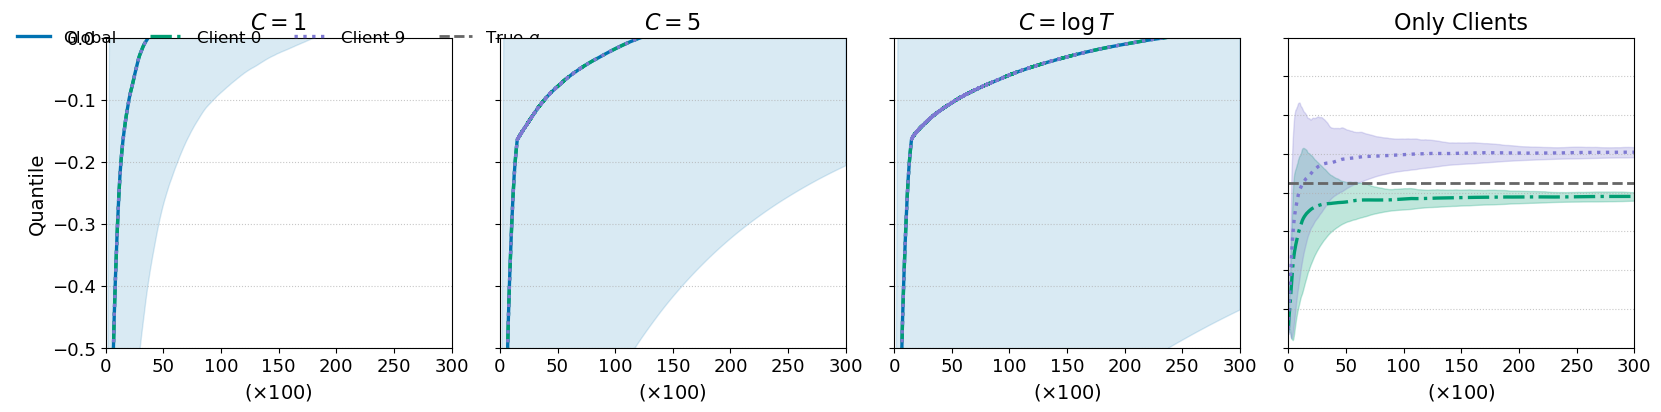

In [37]:
# ============================================================
#  主流程
# ============================================================
taus = np.linspace(0.3, 0.5, 10).tolist()
rs   = [0.9]*10
N    = 30_000

packs = [
    extract_curves(N, mode='federated', E_typ='cons', E_cons=1,
                   taus=taus, rs=rs),
    extract_curves(N, mode='federated', E_typ='cons', E_cons=5,
                   taus=taus, rs=rs),
    extract_curves(N, mode='federated', E_typ='log',  E_cons=5,
                   taus=taus, rs=rs),
    extract_curves(N, mode='global', taus=taus, rs=rs)           # Only Clients
]
titles = [r'$C=1$', r'$C=5$', r'$C=\log T$', r'Only Clients']

fig, axes = plt.subplots(1, 4, figsize=(16.8, 4))
for i, (ax, d, ttl) in enumerate(zip(axes, packs, titles)):
    plot_panel(ax, d, title=ttl,
               show_global=(i < 3),
               y_lims=(-2, 2) if i == 3 else (-0.5, 0),
               show_yticks=(i == 0),
               add_ylabel=(i == 0),
               add_legend=(i == 0))
fig.tight_layout(pad=0.2)
fig.subplots_adjust(wspace=0.14)
plt.show()

In [33]:
# ── 主流程 ──────────────────────────────────────────────
taus = np.linspace(0.3, 0.5, 10).tolist()
rs   = [0.9]*10
N    = 30_000

packs = [
    extract_curves(N, mode='federated', E_typ='cons', E_cons=1,
                   taus=taus, rs=rs),
    extract_curves(N, mode='federated', E_typ='cons', E_cons=5,
                   taus=taus, rs=rs),
    extract_curves(N, mode='federated', E_typ='log',  E_cons=5,
                   taus=taus, rs=rs),
    extract_curves(N, mode='clients', taus=taus, rs=rs)        # Only Clients
]
titles = [r'$C=1$', r'$C=5$', r'$C=\log T$', r'Only Clients']

fig, axes = plt.subplots(1, 4, figsize=(16.8, 4))
for i, (ax, d, ttl) in enumerate(zip(axes, packs, titles)):
    plot_panel(ax, d, title=ttl,
               show_global=(i < 3),
               y_lims=(-2, 2) if i == 3 else (-0.5, 0),
               show_yticks=(i == 0),
               add_ylabel=(i == 0),
               add_legend=(i == 0))
fig.tight_layout(pad=0.2)
fig.subplots_adjust(wspace=0.14)
plt.show()

KeyError: 'true_q'

In [ ]:
# ============================================================
#  Main
# ============================================================
taus = np.linspace(0.3, 0.5, 10).tolist()
rs   = [0.9]*10
N    = 30_000

packs  = [
    extract_curves(N, mode='federated', E_typ='cons', E_cons=1,
                   taus=taus, rs=rs),
    extract_curves(N, mode='federated', E_typ='cons', E_cons=5,
                   taus=taus, rs=rs),
    extract_curves(N, mode='federated', E_typ='log',  E_cons=5,
                   taus=taus, rs=rs),
    extract_curves(N, mode='clients', taus=taus, rs=rs)       # Only Clients
]
titles = [r'$C=1$', r'$C=5$', r'$C=\log T$', r'Only Clients']

fig, axes = plt.subplots(1, 4, figsize=(16.8, 4))
for i, (ax, pk, ttl) in enumerate(zip(axes, packs, titles)):
    plot_pack(ax, pk, title=ttl,
              show_global=(i < 3),
              y_lims=(-2, 2) if i == 3 else (-0.5, 0),
              show_yticks=(i == 0),
              add_ylabel=(i == 0),
              add_legend=(i == 0))
fig.tight_layout(pad=0.2)
fig.subplots_adjust(wspace=0.14)
plt.show()

In [26]:
# ===================================================
# A. 把 get_curves 和 get_curves_global 合并
# ===================================================
def extract_curves(N, *,
                   mode='federated',    # or 'clients'
                   E_typ='cons', E_cons=1,
                   base_seed=2020, n_clients=10,
                   gene_process='hete', taus=0.5, rs=()):
    """返回 dict，统一键：g, c0, c9"""
    if mode == 'clients':          # 仅客户端
        a, b, c = 0.51, 100, 2
        _, traj = run_federated_trajectory(
            dist_type='normal', taus=taus, client_rs=rs,
            n_clients=n_clients, T=N,
            E_typ='cons', E_cons=1, gene_process=gene_process,
            mode='global', T_mode='samples',
            base_seed=base_seed, a=a, b=b, c=c)

        z = 6.74735
        xs0, q0, lo0, up0 = _cli(traj[0], z)
        xs9, q9, lo9, up9 = _cli(traj[9], z)
        true_q            = traj[0]['true_q']

        return dict(xs_g=None, gavg=None, lo_g=None, up_g=None,
                    xs0=xs0, q0=q0, lo0=lo0, up0=up0,
                    xs9=xs9, q9=q9, lo9=lo9, up9=up9,
                    true=true_q)

    # ---------- federated ----------
    a, b, c = get_abc(E_typ, E_cons, rs[0])
    true_q, traj = run_federated_trajectory(
        dist_type='normal', taus=taus, client_rs=rs,
        n_clients=n_clients, T=N,
        E_typ=E_typ, E_cons=E_cons, gene_process=gene_process,
        mode='federated', T_mode='samples',
        base_seed=base_seed, a=a, b=b, c=c)

    z  = 6.753 if E_typ == 'log' else 6.74735
    xs_g, gavg, lo_g, up_g = _g(traj['global'], z)
    xs0, q0, lo0, up0      = _cli(traj['local']['client_0'], z)
    xs9, q9, lo9, up9      = _cli(traj['local']['client_9'], z)

    return dict(xs_g=xs_g, gavg=gavg, lo_g=lo_g, up_g=up_g,
                xs0=xs0, q0=q0, lo0=lo0, up0=up0,
                xs9=xs9, q9=q9, lo9=lo9, up9=up9,
                true=true_q)


def _g(node, z):
    q_hist, v_hist = node['global_q_avg'], node['global_variance']
    xs = np.fromiter(sorted(q_hist), dtype=int)
    q  = np.fromiter((q_hist[k] for k in xs), float)
    v  = np.fromiter((v_hist[k] for k in xs), float)
    return xs, q, q - z*np.sqrt(v), q + z*np.sqrt(v)

def _cli(node, z):
    q_hist, v_hist = node['q_avg'], node['variance']
    xs = np.fromiter(sorted(q_hist), int)
    q  = np.fromiter((q_hist[k] for k in xs), float)
    v  = np.fromiter((v_hist[k] for k in xs), float)
    return xs, q, q - z*np.sqrt(v), q + z*np.sqrt(v)

In [27]:
# ===================================================
# B. 准备曲线
# ===================================================
taus   = np.linspace(0.3, 0.5, 10).tolist()
rs     = [0.9]*10
N      = 30_000
panels = [
    extract_curves(N, mode='federated', E_typ='cons', E_cons=1,
                   taus=taus, rs=rs),
    extract_curves(N, mode='federated', E_typ='cons', E_cons=5,
                   taus=taus, rs=rs),
    extract_curves(N, mode='federated', E_typ='log',  E_cons=5,
                   taus=taus, rs=rs),
    extract_curves(N, mode='clients',   taus=taus, rs=rs)      # Only Clients
]
titles = [r'$C=1$', r'$C=5$', r'$C=\log T$', r'Only Clients']

# ===================================================
# C. 画图
# ===================================================
fig, axes = plt.subplots(1, 4, figsize=(16.8, 4))
for i, (ax, p, ttl) in enumerate(zip(axes, panels, titles)):
    # ---- global (若有) ----
    if p['gavg'] is not None:
        ax.plot(p['xs_g'], p['gavg'], color=COLORS['global'], label='Global')
        ax.fill_between(p['xs_g'], p['lo_g'], p['up_g'],
                        color=COLORS['global'], alpha=0.15)

    # ---- client 0 & 9 ----
    ax.plot(p['xs0'], p['q0'], '-.', color=COLORS['c0'], label='Client 0')
    ax.fill_between(p['xs0'], p['lo0'], p['up0'],
                    color=COLORS['c0'], alpha=0.25)
    ax.plot(p['xs9'], p['q9'], ':',  color=COLORS['c1'], label='Client 9')
    ax.fill_between(p['xs9'], p['lo9'], p['up9'],
                    color=COLORS['c1'], alpha=0.25)

    ax.axhline(p['true'], ls='--', color='gray', lw=2, label=r'True $q$')
    ax.set_xlim(0, 30_000)
    ax.set_ylim((-2, 2) if i == 3 else (-0.5, 0))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/100)}'))
    ax.set_xlabel(r'$(\times 100)$')
    if i == 0:
        ax.set_ylabel('Quantile')
    else:
        ax.set_yticklabels([])
    if i == 0:
        ax.legend(frameon=False, ncol=4, loc='upper center',
                  bbox_to_anchor=(0.5, 1.08))
    ax.set_title(ttl)
    ax.grid(axis='y', ls=':', alpha=0.7)

fig.tight_layout(pad=0.2)
fig.subplots_adjust(wspace=0.14)
plt.show()

KeyError: 'q_avg'

In [7]:
## 
tau = 0.3
gene_process = 'homo'
r = 0.9
rs = [r]*10
configs = [('cons', 1)]
N       = 20_000
seed    = 1

In [ ]:
configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1


# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.8,-0.2))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [24]:
## 
tau = 0.8
gene_process = 'homo'
r = 0.9
rs = [r]*10
configs = [('cons', 1)]
N       = 20_000
seed    = 2

In [25]:
configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=20000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

In [26]:
configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

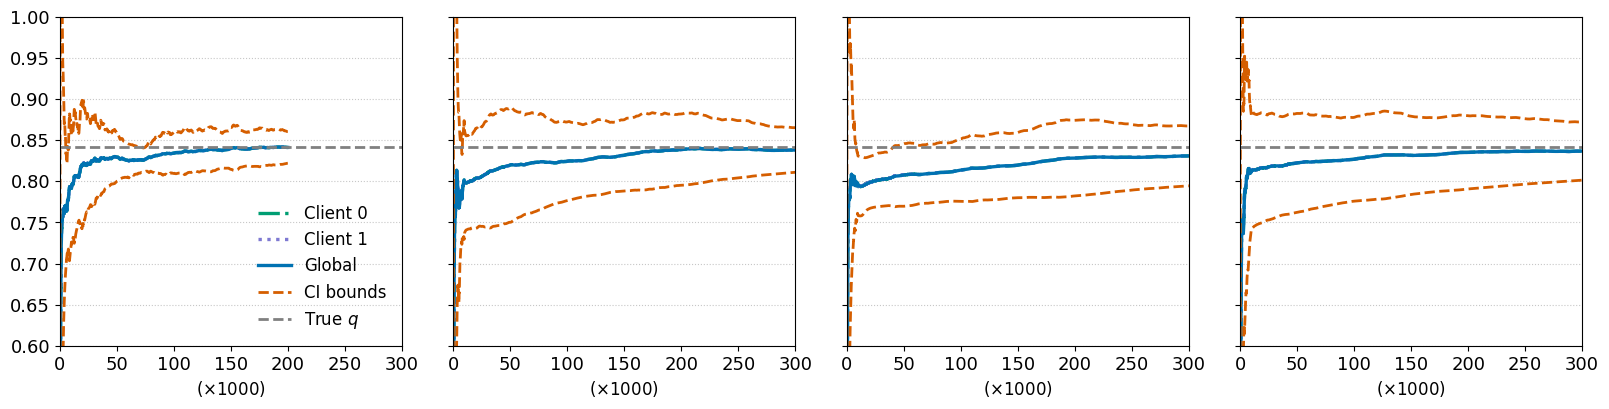

In [27]:
# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(0.6,1.0))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [ ]:
## 
tau = 0.5
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.15,0.15))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()

In [ ]:
## 
tau = 0.3
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.8,-0.2))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()

In [93]:
## 
tau = 0.8
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

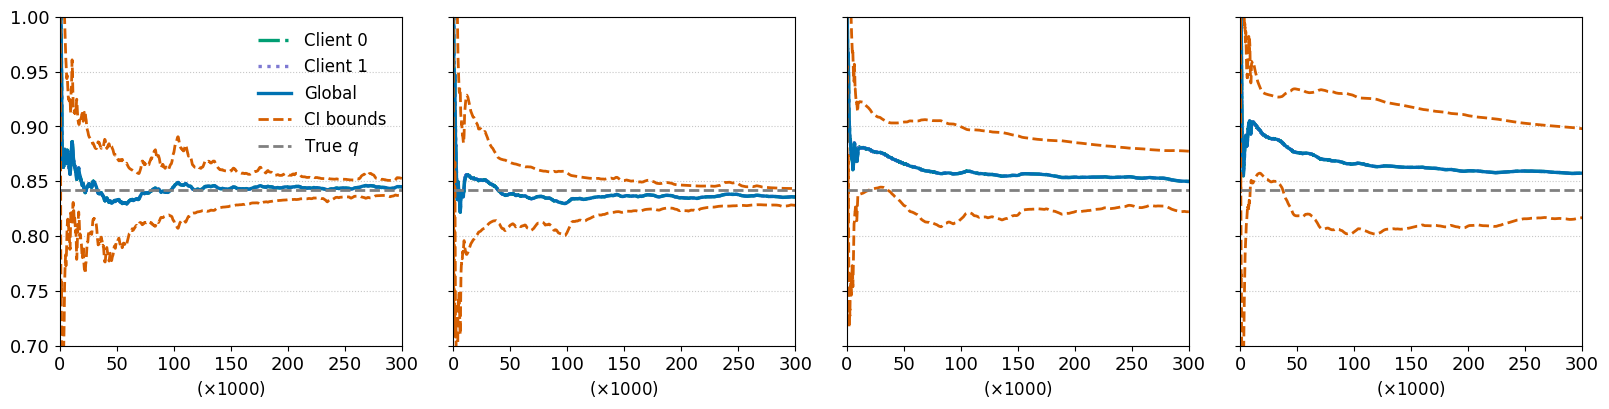

In [96]:
# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000,y_lims=(0.7,1.0))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()